# Data Handling and Preparation

## Import Python Packages

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)

from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import  functional as F
import torch.optim as optim

from sklearn.metrics import *

## Data Processing

In [285]:
# Load the datasets
x_train = np.load('X_train.npy')
x_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')

x_train_df = pd.DataFrame(x_train, columns=[f"x{i}" for i in range(1, 112)])
y_train_df = pd.DataFrame(y_train, columns=[f"y{i}" for i in range(1, 12)])

# Check the shape of the datasets
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(1000, 111)
(700, 111)
(1000, 11)


In [286]:
np.unique(y_train)

array([0, 1])

In [287]:
unique_counts = {}
for column in y_train_df.columns:
    unique_counts[column] = y_train_df[column].value_counts().to_dict()

# 打印结果
for label, counts in unique_counts.items():
    print(f"Counts for label {label}: {counts}")

Counts for label y1: {0: 720, 1: 280}
Counts for label y2: {0: 787, 1: 213}
Counts for label y3: {0: 779, 1: 221}
Counts for label y4: {0: 769, 1: 231}
Counts for label y5: {0: 766, 1: 234}
Counts for label y6: {0: 730, 1: 270}
Counts for label y7: {0: 780, 1: 220}
Counts for label y8: {0: 756, 1: 244}
Counts for label y9: {0: 606, 1: 394}
Counts for label y10: {0: 727, 1: 273}
Counts for label y11: {0: 737, 1: 263}


In [288]:
print(f'There are {x_train_df.isnull().any().sum()} columns in train dataset with missing values.')
print(f'There are {x_train_df.isnull().any(axis=1).sum()} rows in train dataset with missing values.')

There are 109 columns in train dataset with missing values.
There are 1000 rows in train dataset with missing values.


## Remove Rows/Columns with More Than 40% Missing Values

In [289]:
have_null_fea_dict = (x_train_df.isnull().sum()/len(x_train_df)).to_dict()
fea_null_moreThan40 = {}
for key, value in have_null_fea_dict.items():
    if value > 0.4:
        fea_null_moreThan40[key] = value
print(f"missing value in column more than 40%:")
print(fea_null_moreThan40)

missing value in column more than 40%:
{'x7': 0.963, 'x34': 0.644, 'x35': 0.644, 'x88': 0.998}


In [290]:
# 计算每行的缺失值比例
have_null_fea_row_dict = (x_train_df.isnull().sum(
    axis=1)/x_train_df.shape[1]).to_dict()

# 找出缺失值超过40%的行
fea_null_moreThan40_row = {}
for key, value in have_null_fea_row_dict.items():
    if value > 0.4:
        fea_null_moreThan40_row[key] = value
print(f"missing value in column more than 40%:")
print(fea_null_moreThan40_row)

missing value in column more than 40%:
{21: 0.5405405405405406, 711: 0.43243243243243246, 849: 0.4864864864864865}


In [291]:
x_train_df.drop(columns=fea_null_moreThan40, inplace=True)
x_train_df.drop(fea_null_moreThan40_row.keys(), inplace=True)
y_train_df.drop(fea_null_moreThan40_row.keys(), inplace=True)
x_train_df.shape, y_train_df.shape

((997, 107), (997, 11))

##  Imputation of Missing Values and Standardization

In [292]:
# 缺失值填充为中位数

num_cols = x_train_df.columns
# num_cols
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler()) #均值-标准差归一化
num_steps = [num_si_step, num_ss_step]

num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]

ct = ColumnTransformer(transformers=num_transformers)

x_all = ct.fit_transform(x_train_df)
x_all.shape

(997, 107)

In [293]:
y_all = y_train_df.values
y_all.shape

(997, 11)

## Splitting into Training and Testing Sets

In [294]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((797, 107), (200, 107), (797, 11), (200, 11))

## Prepare PyTorch Dataset and DataLoader

In [295]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cpu device


In [296]:
# dataset

from torch.utils.data import TensorDataset

train_ds = TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float())
train_all_ds = TensorDataset(torch.tensor(x_all).float(), torch.tensor(y_all).float())
test_ds = TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float())

In [297]:
# dataloader

batch_size = 12
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# train_all_dl = DataLoader(train_all_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [298]:
# check shape

for b_x, b_y in test_dl:
  print(b_x.shape)
  print(b_y.shape)
  break

torch.Size([12, 107])
torch.Size([12, 11])


# Construct Training and Evaluation Functions

In [122]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        # loss = loss_fn(pred, y)
        loss = loss_fn(pred, y.type(torch.float))
        # batch_loss_value = loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [123]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # correct /= size
    print(f"Test Error: \n  Avg loss: {test_loss:>8f} \n")
    return test_loss

In [124]:
dim_num = x_all.shape[1]
dim_num

107

In [125]:
n_classes = 11

# (1) CNN model (SGD optimizer)



## Build Model

In [85]:
class CNNMblock(nn.Module):
    def __init__(self,):
        super().__init__()
        self.nor = nn.BatchNorm1d(dim_num)
        self.cnn = nn.Conv1d(dim_num,8,1)
        self.out = nn.Linear(8, n_classes)
        self.flatten = nn.Flatten()
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        # x = self.nor(x)
        x = x.view(-1,dim_num,1)
        # print(x.shape)
        x= self.cnn(x)
        x = self.flatten(x)
        x = self.out(x)
        x = self.sigm(x)

        return x

cnn_model = CNNMblock().to(device)


cnn_model(b_x.to(device)).shape

torch.Size([12, 11])

## Optimizer

In [86]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=1e-3)

## Training and Evaluation

In [87]:
epochs = 40
train_loss_list = []
test_loss_list = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, cnn_model, loss_fn, optimizer)
    train_loss = test(train_dl, cnn_model, loss_fn)
    test_loss= test(test_dl, cnn_model, loss_fn)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

print("Done!")

Epoch 1
-------------------------------
loss: 0.746446  [    0/  797]
loss: 0.720326  [  600/  797]
Test Error: 
  Avg loss: 0.729244 

Test Error: 
  Avg loss: 0.726314 

Epoch 2
-------------------------------
loss: 0.732168  [    0/  797]
loss: 0.749014  [  600/  797]
Test Error: 
  Avg loss: 0.728948 

Test Error: 
  Avg loss: 0.725754 

Epoch 3
-------------------------------
loss: 0.714928  [    0/  797]
loss: 0.726950  [  600/  797]
Test Error: 
  Avg loss: 0.728393 

Test Error: 
  Avg loss: 0.725197 

Epoch 4
-------------------------------
loss: 0.745593  [    0/  797]
loss: 0.738946  [  600/  797]
Test Error: 
  Avg loss: 0.727524 

Test Error: 
  Avg loss: 0.724642 

Epoch 5
-------------------------------
loss: 0.706982  [    0/  797]
loss: 0.728303  [  600/  797]
Test Error: 
  Avg loss: 0.726850 

Test Error: 
  Avg loss: 0.724089 

Epoch 6
-------------------------------
loss: 0.724482  [    0/  797]
loss: 0.724164  [  600/  797]
Test Error: 
  Avg loss: 0.726286 

Test

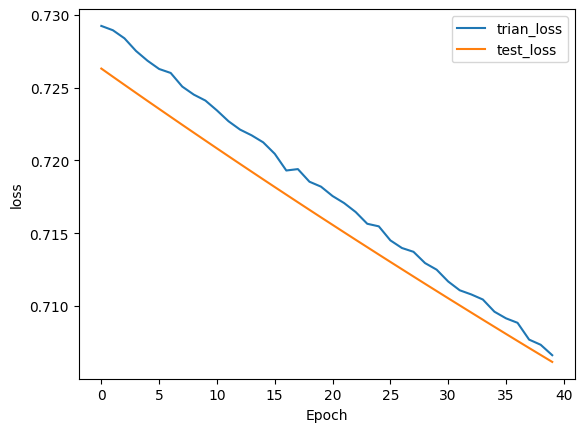

In [88]:
# 损失函数图像

plt.plot(train_loss_list, label='trian_loss')
plt.plot(test_loss_list, label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

## Analysis

### accuracy and F1

In [89]:
import torch
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, average_precision_score

# 定义评估函数
def evaluate(model, dataloader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = (outputs > 0.5).int()
            y_true.append(labels.cpu().numpy())
            y_pred.append(predictions.cpu().numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    hamming = hamming_loss(y_true, y_pred)
    accuracy1 = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy2 = accuracy_score(y_true.flatten(), y_pred.flatten())
    return hamming, accuracy1, accuracy2, f1, y_true, y_pred

# 计算评估指标
hamming, accuracy1, accuracy2, f1, y_true, y_pred = evaluate(cnn_model, test_dl)
print("Hamming Loss:", hamming)
print("Exact Match Ratio:", accuracy1)
print("accuracy:", accuracy2)
print("F1 Score:", f1)

Hamming Loss: 0.52
Exact Match Ratio: 0.0
accuracy: 0.48
F1 Score: 0.33326761192133403


### classification report

In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.27      0.38      0.32        52
           1       0.26      0.54      0.35        41
           2       0.22      0.47      0.30        49
           3       0.27      0.68      0.39        53
           4       0.21      0.90      0.34        41
           5       0.23      0.31      0.27        55
           6       0.23      0.70      0.35        50
           7       0.20      0.54      0.30        39
           8       0.45      0.30      0.36        84
           9       0.31      0.83      0.45        63
          10       0.23      0.25      0.24        48

   micro avg       0.26      0.52      0.34       575
   macro avg       0.26      0.54      0.33       575
weighted avg       0.28      0.52      0.34       575
 samples avg       0.25      0.50      0.32       575



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

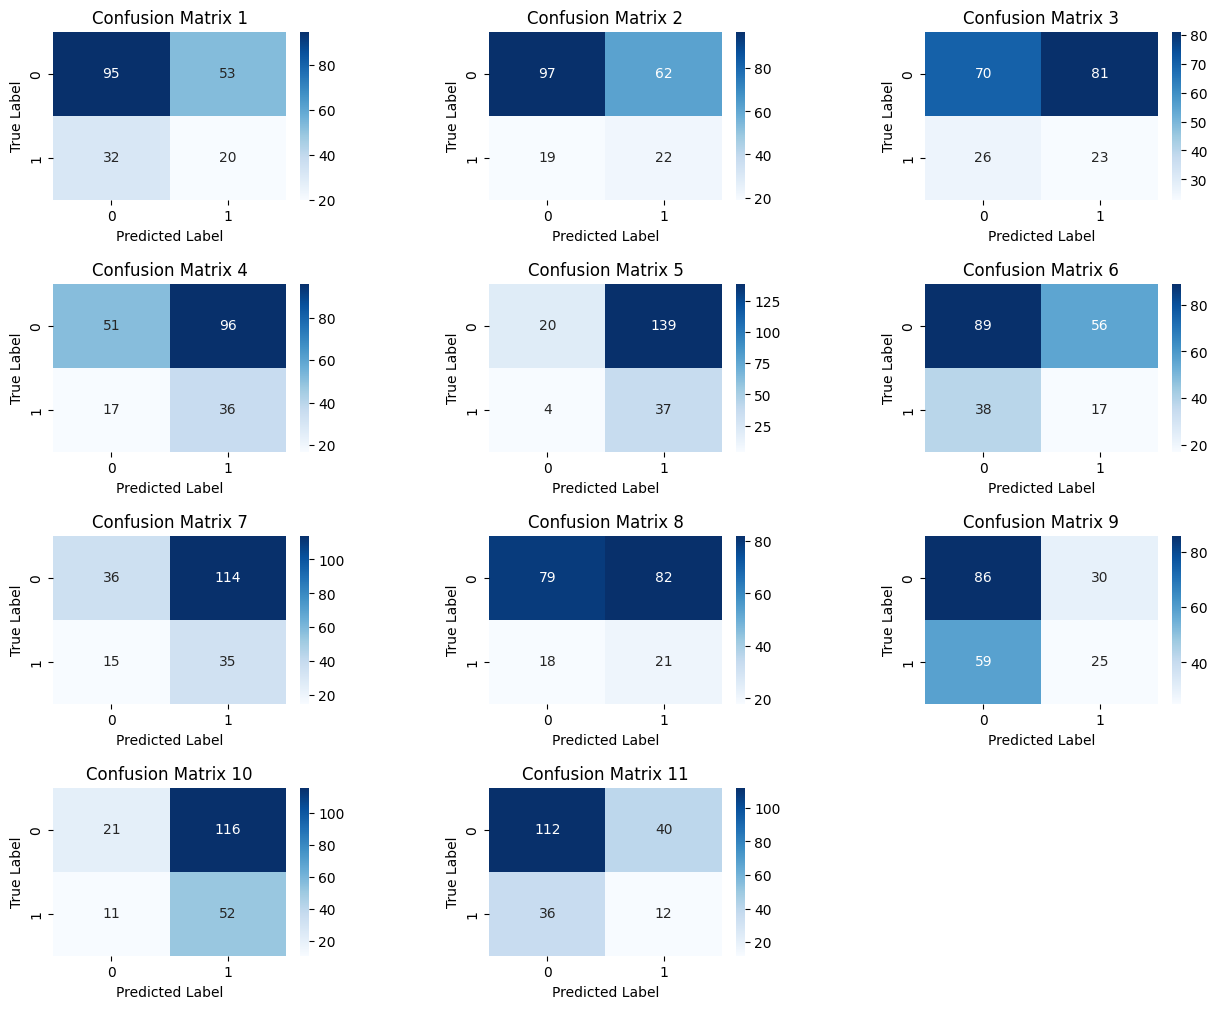

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# 生成混淆矩阵
confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)

# 创建一个4x3的子图布局
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()  # 将axes转换为一维列表

# 遍历confusion_matrix和axes
for i, (cm, ax) in enumerate(zip(confusion_matrix, axes[:11])):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix {i+1}')

# 清空最后一个子图
axes[-1].axis('off')

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# 显示图像
plt.show()

# (2) CNN model (AdamW optimizer) -- Almost the same

## Build Model

In [299]:
class CNNMblock(nn.Module):
    def __init__(self,):
        super().__init__()
        self.nor = nn.BatchNorm1d(dim_num)
        self.cnn = nn.Conv1d(dim_num,8,1)
        self.out = nn.Linear(8, n_classes)
        self.flatten = nn.Flatten()
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        # x = self.nor(x)
        x = x.view(-1,dim_num,1)
        # print(x.shape)
        x= self.cnn(x)
        x = self.flatten(x)
        x = self.out(x)
        x = self.sigm(x)

        return x

cnn_model = CNNMblock().to(device)


cnn_model(b_x.to(device)).shape

torch.Size([12, 11])

## Optimizer

In [300]:
optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-4, weight_decay=0.01)

## Training and Evaluation

In [301]:
epochs = 15
train_loss_list = []
test_loss_list = []
loss_fn = nn.BCELoss()

for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, cnn_model, loss_fn, optimizer)
    train_loss = test(train_dl, cnn_model, loss_fn)
    test_loss= test(test_dl, cnn_model, loss_fn)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

print("Done!")

loss: 0.734523  [    0/  797]
loss: 0.717769  [  600/  797]
Test Error: 
  Avg loss: 0.728999 

Test Error: 
  Avg loss: 0.720811 

loss: 0.739123  [    0/  797]
loss: 0.722992  [  600/  797]
Test Error: 
  Avg loss: 0.725930 

Test Error: 
  Avg loss: 0.718587 

loss: 0.721832  [    0/  797]
loss: 0.702913  [  600/  797]
Test Error: 
  Avg loss: 0.723132 

Test Error: 
  Avg loss: 0.716429 

loss: 0.706906  [    0/  797]
loss: 0.708730  [  600/  797]
Test Error: 
  Avg loss: 0.720355 

Test Error: 
  Avg loss: 0.714232 

loss: 0.698685  [    0/  797]
loss: 0.717358  [  600/  797]
Test Error: 
  Avg loss: 0.717610 

Test Error: 
  Avg loss: 0.712061 

loss: 0.699120  [    0/  797]
loss: 0.710618  [  600/  797]
Test Error: 
  Avg loss: 0.714805 

Test Error: 
  Avg loss: 0.709961 

loss: 0.718754  [    0/  797]
loss: 0.712570  [  600/  797]
Test Error: 
  Avg loss: 0.712198 

Test Error: 
  Avg loss: 0.707879 

loss: 0.694110  [    0/  797]
loss: 0.713027  [  600/  797]
Test Error: 
  A

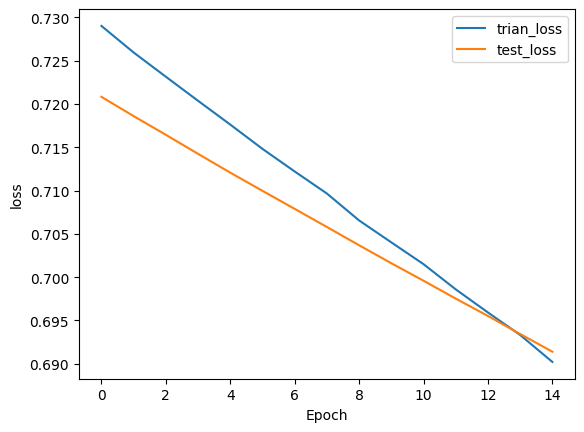

In [302]:
# 损失函数图像

plt.plot(train_loss_list, label='trian_loss')
plt.plot(test_loss_list, label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

## Analysis

### accuracy and F1

In [303]:
import torch
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, average_precision_score

# 定义评估函数
def evaluate(model, dataloader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = (outputs > 0.5).int()
            y_true.append(labels.cpu().numpy())
            y_pred.append(predictions.cpu().numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    hamming = hamming_loss(y_true, y_pred)
    accuracy1 = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy2 = accuracy_score(y_true.flatten(), y_pred.flatten())
    return hamming, accuracy1, accuracy2, f1, y_true, y_pred

In [304]:
# 计算评估指标
hamming, accuracy1, accuracy2, f1, y_true, y_pred = evaluate(cnn_model, test_dl)
print("Hamming Loss:", hamming)
print("Exact Match Ratio:", accuracy1)
print("accuracy:", accuracy2)
print("F1 Score:", f1)

Hamming Loss: 0.475
Exact Match Ratio: 0.005
accuracy: 0.525
F1 Score: 0.3110475652001247


### classification report

In [305]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.28      0.62      0.39        52
           1       0.22      0.68      0.33        41
           2       0.27      0.78      0.40        49
           3       0.29      0.49      0.37        53
           4       0.27      0.20      0.23        41
           5       0.30      0.89      0.44        55
           6       0.30      0.06      0.10        50
           7       0.21      0.87      0.34        39
           8       0.43      0.24      0.31        84
           9       0.30      0.68      0.42        63
          10       0.21      0.06      0.10        48

   micro avg       0.27      0.49      0.35       575
   macro avg       0.28      0.51      0.31       575
weighted avg       0.29      0.49      0.32       575
 samples avg       0.27      0.46      0.32       575



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

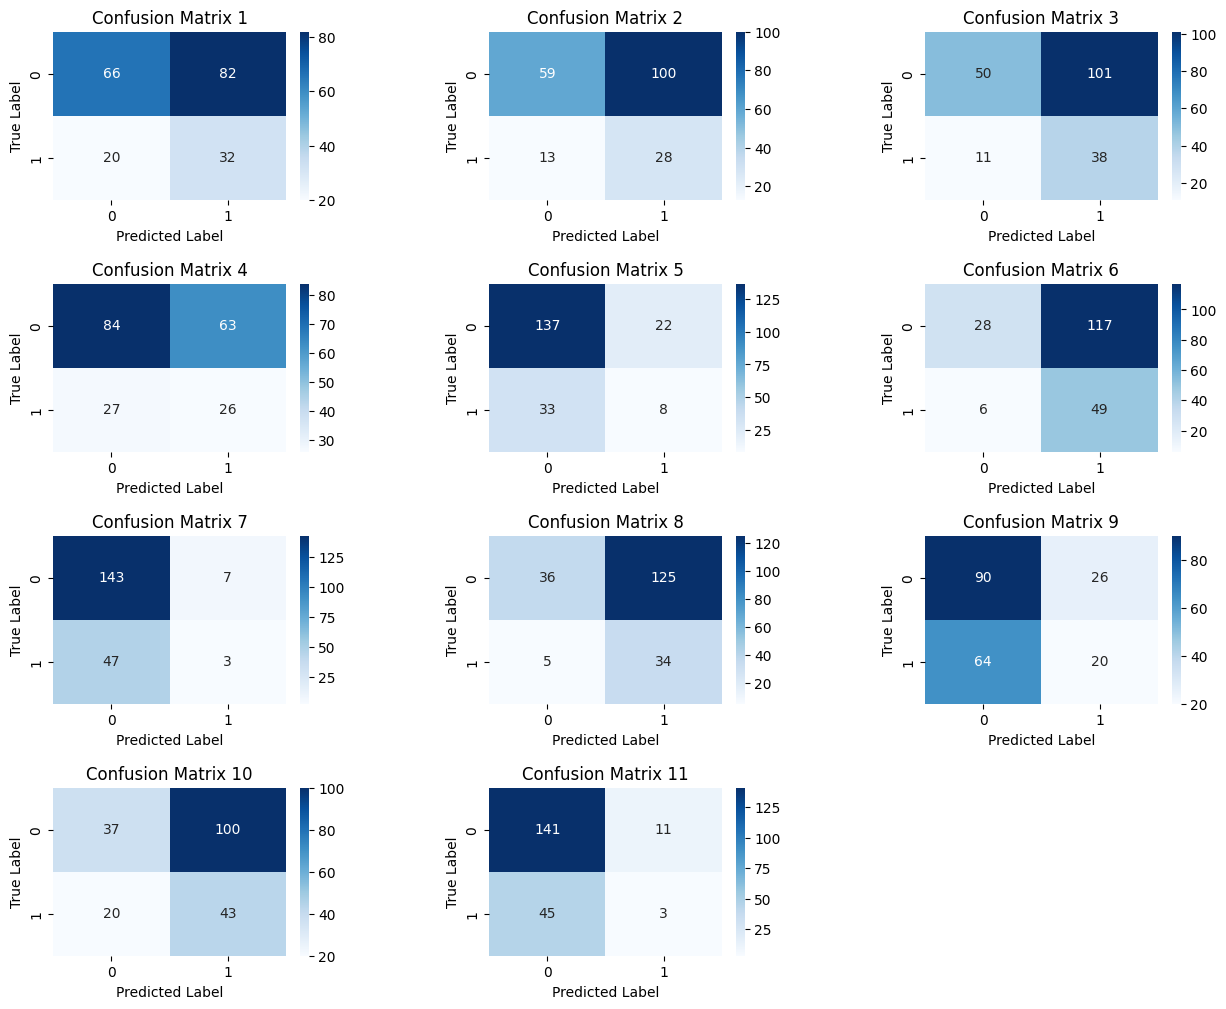

In [306]:
import matplotlib.pyplot as plt
import seaborn as sns

# 生成混淆矩阵
confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)

# 创建一个4x3的子图布局
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()  # 将axes转换为一维列表

# 遍历confusion_matrix和axes
for i, (cm, ax) in enumerate(zip(confusion_matrix, axes[:11])):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix {i+1}')

# 清空最后一个子图
axes[-1].axis('off')

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# 显示图像
plt.show()

# (3) Two-layer CNN model -- Unnecessary

## Build Model

In [229]:
class CNNMblock(nn.Module):
    def __init__(self,):
        super().__init__()
        self.nor = nn.BatchNorm1d(dim_num)
        self.cnn1 = nn.Conv1d(dim_num,6,1)
        self.cnn2 = nn.Conv1d(6,4,1)
        self.out = nn.Linear(4, n_classes)
        self.flatten = nn.Flatten()
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1,dim_num,1)
        x= self.cnn1(x)
        x= self.cnn2(x)
        x = self.flatten(x)
        x = self.out(x)
        x = self.sigm(x)
        return x

cnn_model = CNNMblock().to(device)
cnn_model(b_x.to(device)).shape

torch.Size([12, 11])

## Optimizer

In [230]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=1e-3)


## Training and Evaluation

In [231]:
epochs = 30
train_loss_list = []
test_loss_list = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, cnn_model, loss_fn, optimizer)
    train_loss = test(train_dl, cnn_model, loss_fn)
    test_loss= test(test_dl, cnn_model, loss_fn)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

print("Done!")

Epoch 1
-------------------------------
loss: 0.756703  [    0/  797]
loss: 0.741674  [  600/  797]
Test Error: 
  Avg loss: 0.737059 

Test Error: 
  Avg loss: 0.737044 

Epoch 2
-------------------------------
loss: 0.702251  [    0/  797]
loss: 0.721178  [  600/  797]
Test Error: 
  Avg loss: 0.736247 

Test Error: 
  Avg loss: 0.736315 

Epoch 3
-------------------------------
loss: 0.741688  [    0/  797]
loss: 0.767177  [  600/  797]
Test Error: 
  Avg loss: 0.735425 

Test Error: 
  Avg loss: 0.735591 

Epoch 4
-------------------------------
loss: 0.752524  [    0/  797]
loss: 0.726550  [  600/  797]
Test Error: 
  Avg loss: 0.734941 

Test Error: 
  Avg loss: 0.734870 

Epoch 5
-------------------------------
loss: 0.722960  [    0/  797]
loss: 0.737406  [  600/  797]
Test Error: 
  Avg loss: 0.734136 

Test Error: 
  Avg loss: 0.734150 

Epoch 6
-------------------------------
loss: 0.723993  [    0/  797]
loss: 0.735277  [  600/  797]
Test Error: 
  Avg loss: 0.733401 

Test

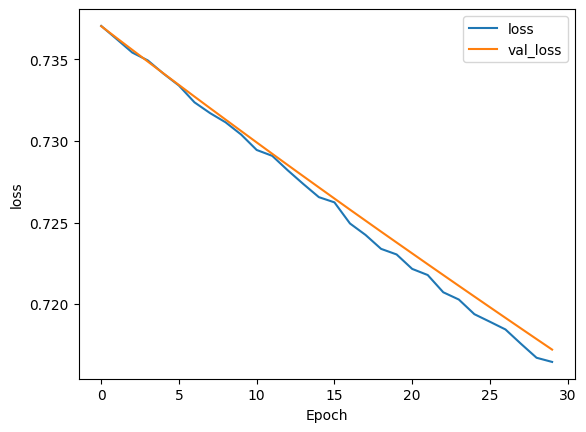

In [232]:
plt.plot(train_loss_list, label='loss')
plt.plot(test_loss_list, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

## Analysis

### accuracy and F1

In [233]:
import torch
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, average_precision_score

# 定义评估函数
def evaluate(model, dataloader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = (outputs > 0.5).int()
            y_true.append(labels.cpu().numpy())
            y_pred.append(predictions.cpu().numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    hamming = hamming_loss(y_true, y_pred)
    accuracy1 = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy2 = accuracy_score(y_true.flatten(), y_pred.flatten())
    return hamming, accuracy1,accuracy2, f1,y_true,y_pred

# 计算评估指标
hamming, accuracy1,accuracy2, f1,y_true,y_pred = evaluate(cnn_model, test_dl)
print("Hamming Loss:", hamming)
print("Exact Match Ratio:", accuracy1)
print("accuracy:", accuracy2)
print("F1 Score:", f1)


Hamming Loss: 0.5627272727272727
Exact Match Ratio: 0.0
accuracy: 0.43727272727272726
F1 Score: 0.3346769271596521


### classification report

In [234]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.26      1.00      0.41        52
           1       0.21      1.00      0.34        41
           2       0.28      0.39      0.32        49
           3       0.00      0.00      0.00        53
           4       0.21      0.98      0.34        41
           5       0.28      0.93      0.43        55
           6       0.24      0.58      0.34        50
           7       0.20      0.03      0.05        39
           8       0.42      0.98      0.58        84
           9       0.37      0.65      0.47        63
          10       0.24      0.98      0.38        48

   micro avg       0.27      0.70      0.39       575
   macro avg       0.25      0.68      0.33       575
weighted avg       0.26      0.70      0.36       575
 samples avg       0.28      0.68      0.37       575



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### confusion matrix

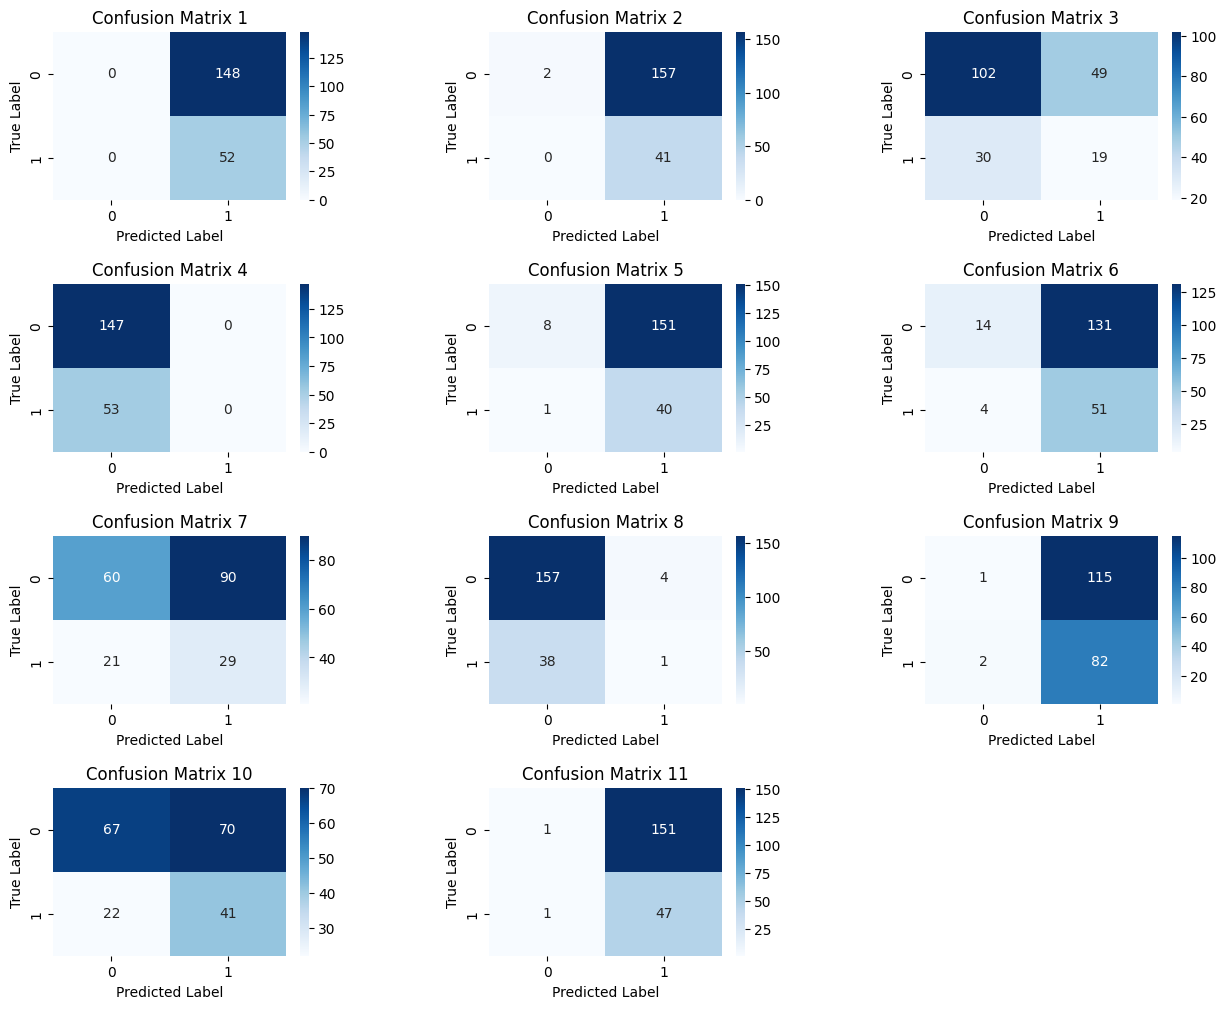

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns

# 生成混淆矩阵
confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)

# 创建一个4x3的子图布局
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()  # 将axes转换为一维列表

# 遍历confusion_matrix和axes
for i, (cm, ax) in enumerate(zip(confusion_matrix, axes[:11])):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix {i+1}')

# 清空最后一个子图
axes[-1].axis('off')

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# 显示图像
plt.show()